In [216]:
setwd("/Users/rebecca/sudmant/analyses/myotis/analysis/reciprocal_best_hits/contextualize_best_hits")

library(dplyr, verbose = FALSE)
library(tidyr)
library(scales)
library(ggplot2)
library(data.table)
library(RColorBrewer)

myo_meta <- read.csv("../../../data/myotis_meta.csv")

In [ ]:
## Plot summary of peaks in reciprocal regions:

for (i in seq_along(myo_meta$Abbr)) {
  
  for (j in seq_along(myo_meta$Abbr)) {

    if (i != j) {

      # pdf(file = paste0("results/myo_meta$Abbr[i], "_vs_", myo_meta$Abbr[j]_best_hits_peak_summary.pdf"), width = 7, height = 6)

      peaks1 <- fread(
        file.path("resources/genes/peaks", 
        list.files(path = "resources/genes/peaks", pattern = paste0(myo_meta$Abbr[i], "_vs_", myo_meta$Abbr[j], ".*_peaks.csv"))),
        data.table = FALSE
        )
      peaks2 <- fread(
        file.path("resources/genes/peaks", 
        list.files(path = "resources/genes/peaks", pattern = paste0(myo_meta$Abbr[j], "_vs_", myo_meta$Abbr[i], ".*_peaks.csv"))),
        data.table = FALSE
        )

      peaks1$Reciprocal_Seq <- with(peaks1, paste(Chr, Reciprocal_Start, Reciprocal_End))
      peaks2$Reciprocal_Seq <- with(peaks2, paste(Chr, Reciprocal_Start, Reciprocal_End))
      peaks1$Reciprocal_Length <- as.numeric(with(peaks1, Reciprocal_End - Reciprocal_Start))
      peaks2$Reciprocal_Length <- as.numeric(with(peaks2, Reciprocal_End - Reciprocal_Start))
      peaks1$Peak_Length <- as.numeric(with(peaks1, paste(Peak_End - Peak_Start)))
      peaks2$Peak_Length <- as.numeric(with(peaks2, paste(Peak_End - Peak_Start)))

      peaks1_df <- peaks1 %>%
        dplyr::group_by(Chr, Reciprocal_Seq) %>% 
        dplyr::summarise(
          No.Peaks = n(),
          No.Peaks_Rel = n()/unique(Reciprocal_Length)
        )

      peaks2_df <- peaks2 %>%
        dplyr::group_by(Chr, Reciprocal_Seq) %>% 
        dplyr::summarise(
          No.Peaks = n(),
          No.Peaks_Rel = n()/unique(Reciprocal_Length)
        )

      ## Plot distro of peak lengths:

      print(
        ggplot(peaks1, aes(x = Peak_Length)) + 
          geom_histogram(bins = 100) +
          theme_minimal() +
          theme(axis.title.x = element_text(margin = margin(t = 15)),
                axis.title.y = element_blank()) +
          labs(title = paste(myo_meta$Abbr[i], "peaks in reciprocal regions with", myo_meta$Abbr[j])) +
          xlab("Peak length (nt)") +
          scale_x_continuous(labels = comma) +
          scale_y_continuous(labels = comma)
      )

      print(
        ggplot(peaks2, aes(x = Peak_Length)) + 
          geom_histogram(bins = 100) +
          theme_minimal() +
          theme(axis.title.x = element_text(margin = margin(t = 15)),
                axis.title.y = element_blank()) +
          labs(title = paste(myo_meta$Abbr[j], "peaks in reciprocal regions with", myo_meta$Abbr[i])) +
          xlab("Peak length (nt)") +
          scale_x_continuous(labels = comma) +
          scale_y_continuous(labels = comma)
      )

      ## Plot distro of # of peaks per reciprocal region:

      print(
        ggplot(peaks1_df, aes(x = No.Peaks)) + 
          geom_histogram(bins = 50) +
          theme_minimal() +
          theme(axis.title.x = element_text(margin = margin(t = 15)),
                axis.title.y = element_blank()) +
          labs(title = paste(myo_meta$Abbr[i], "peaks in reciprocal regions with", myo_meta$Abbr[j])) +
          xlab("# peaks per region") +
          scale_x_continuous(labels = comma)
      )

      print(
        ggplot(peaks2_df, aes(x = No.Peaks)) + 
          geom_histogram(bins = 50) +
          theme_minimal() +
          theme(axis.title.x = element_text(margin = margin(t = 15)),
                axis.title.y = element_blank()) +
          labs(title = paste(myo_meta$Abbr[j], "peaks in reciprocal regions with", myo_meta$Abbr[i])) +
          xlab("# peaks per region") +
          scale_x_continuous(labels = comma)
      )

      # print(
      #   ggplot(peaks1_df, aes(No.Peaks_Rel)) +
      #     geom_histogram(bins = 30) +
      #     theme_minimal() +
      #     theme(axis.title.x = element_text(margin = margin(t = 15)),
      #           axis.title.y = element_blank()) +
      #     labs(title = paste(myo_meta$Abbr[i], "peaks in reciprocal regions with", myo_meta$Abbr[j])) +
      #     xlab("# peaks per nucleotide in reciprocal regions") +
      #     scale_x_continuous(breaks = seq(0, 1, by = .00005))
      # )

      # dev.off()

    }
  }
}

In [ ]:
## How do peaks in orthologous genes compare?

i = 1

for (i in seq_along(myo_meta$Abbr)) {

  ## Load in peak data for species 1: 
  ## peaks in reciprocal regions that intersect orthologous genes
  peaks1_genes <- fread(
    file.path("resources/genes/peaks", 
    list.files(path = "resources/genes/peaks", pattern = paste0(myo_meta$Abbr[i], "_vs_", myo_meta$Abbr[j], ".*_only.csv"))),
    data.table = FALSE
    )
  peaks1_genes <- peaks1_genes %>%
  dplyr::group_by(myotis_ali_fn) %>%
  dplyr::slice_max(as.numeric(Intersect_Start)) %>%
  dplyr::select(myotis_ali_fn, Peak_ID)

  ## Load in peak data for species 1: 
  ## Species 1 orthologous genes in reciprocal best hit regions:
  hits1_genes <- fread(
    file.path("resources/genes", 
    list.files(path = "resources/genes", pattern = paste0(myo_meta$Abbr[i], "_vs_", myo_meta$Abbr[j], ".*_only.csv"))),
    data.table = FALSE
    )
  hits1_genes <- hits1_genes %>%
    dplyr::mutate(Reciprocal_Seq = paste(Chr, Reciprocal_Start, Reciprocal_End)) %>%
    dplyr::group_by(Chr, myotis_ali_fn, Reciprocal_Seq) %>%
    dplyr::summarise(human_gene_name = unique(human_gene_name))

  inds <- seq_along(myo_meta$Abbr)

}


In [225]:

  spec2_data <- suppressMessages(lapply(inds[inds != i], function(j) {

    ## Load in peak data for species 2: 
    ## peaks in reciprocal regions that intersect orthologous genes
    peaks2_genes <- fread(
      file.path("resources/genes/peaks", 
      list.files(path = "resources/genes/peaks", pattern = paste0(myo_meta$Abbr[j], "_vs_", myo_meta$Abbr[i], ".*_only.csv"))),
      data.table = FALSE
    )
    peaks2_genes <- peaks2_genes %>%
      dplyr::group_by(myotis_ali_fn) %>%
      dplyr::slice_max(as.numeric(Intersect_Start)) %>%
      dplyr::select(Peak_ID)

    ## Load in peak data for species 2: 
    ## Species 1 orthologous genes in reciprocal best hit regions:  
    hits2_genes <- fread(
      file.path("resources/genes", 
      list.files(path = "resources/genes", pattern = paste0(myo_meta$Abbr[j], "_vs_", myo_meta$Abbr[i], ".*_only.csv"))),
      data.table = FALSE
    )
    hits2_genes <- hits2_genes %>%
      dplyr::mutate(Reciprocal_Seq = paste(Chr, Reciprocal_Start, Reciprocal_End)) %>%
      dplyr::group_by(Chr, myotis_ali_fn, Reciprocal_Seq) %>%
      dplyr::summarise(human_gene_name = unique(human_gene_name))

    ## Genes not present in peak files implies no peak at that location:
    hits1_status <- merge(hits1_genes, peaks1_genes, by = "myotis_ali_fn", all.x = TRUE)
    hits1_status$Peak <- TRUE
    hits1_status$Peak[is.na(hits1_status$Peak_ID)] <- FALSE
    hits2_status <- merge(hits2_genes, peaks2_genes, by = "myotis_ali_fn", all.x = TRUE)
    hits2_status$Peak <- TRUE
    hits2_status$Peak[is.na(hits2_status$Peak_ID)] <- FALSE

    ## Subset to orthologous genes present in both species:
    hits1_status <- hits1_status[hits1_status$myotis_ali_fn %in% hits2_status$myotis_ali_fn,]
    hits2_status <- hits2_status[match(hits1_status$myotis_ali_fn, hits2_status$myotis_ali_fn),]
    if (!identical(hits2_status$myotis_ali_fn, hits1_status$myotis_ali_fn)) {
      print(paste(i, j))
      stop("Genes do not match between species")
    }

    ## Correlation between peak status in orthologous genes:
    peak_cor <- cor(hits1_status$Peak, hits2_status$Peak)
    
    ## Of the orthologous genes in species 1, what fraction of them have differential peaks to species 2?
    is_diff <- hits1_status$Peak != hits2_status$Peak
    frac_diff <- as.matrix(table(is_diff))
  
    hits1_diff <- hits1_status[is_diff,]
    hits2_diff <- hits2_status[is_diff,]

    ## Summarize results:
    peak_df <- data.frame(
      Species = myo_meta$Field_Name[j],
      Cor = peak_cor,
      Is_Diff = rownames(frac_diff),
      No.Peaks = as.numeric(frac_diff[,1]), 
      Frac = as.numeric(frac_diff[,1])/length(is_diff)
    )
    
    return(peak_df)
    
  }))

[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9


In [224]:
df <- do.call(rbind, spec2_data)
head(df)

,Species,Cor,Is_Diff,No.Peaks,Frac
,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,Myotis-Californicus,0.3308670,FALSE,5829,0.7625589
2,Myotis-Californicus,0.3308670,TRUE,1815,0.2374411
3,Myotis-Evotis,0.3594486,FALSE,7740,0.7931953
4,Myotis-Evotis,0.3594486,TRUE,2018,0.2068047
5,Myotis-Lucifugus,0.2980322,FALSE,5204,0.7964493
6,Myotis-Lucifugus,0.2980322,TRUE,1330,0.2035507


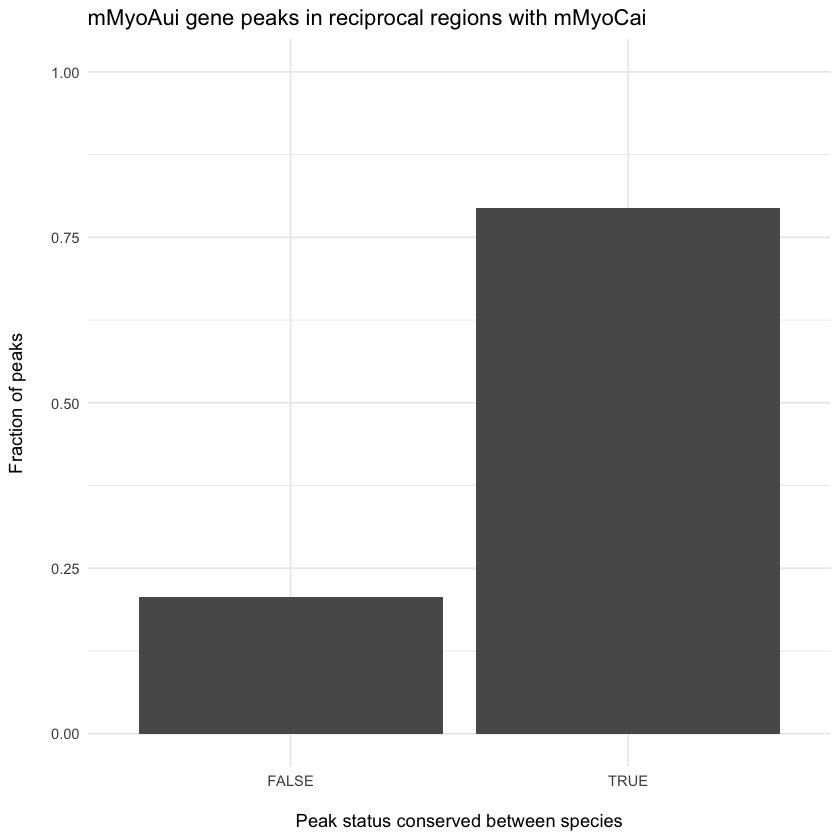

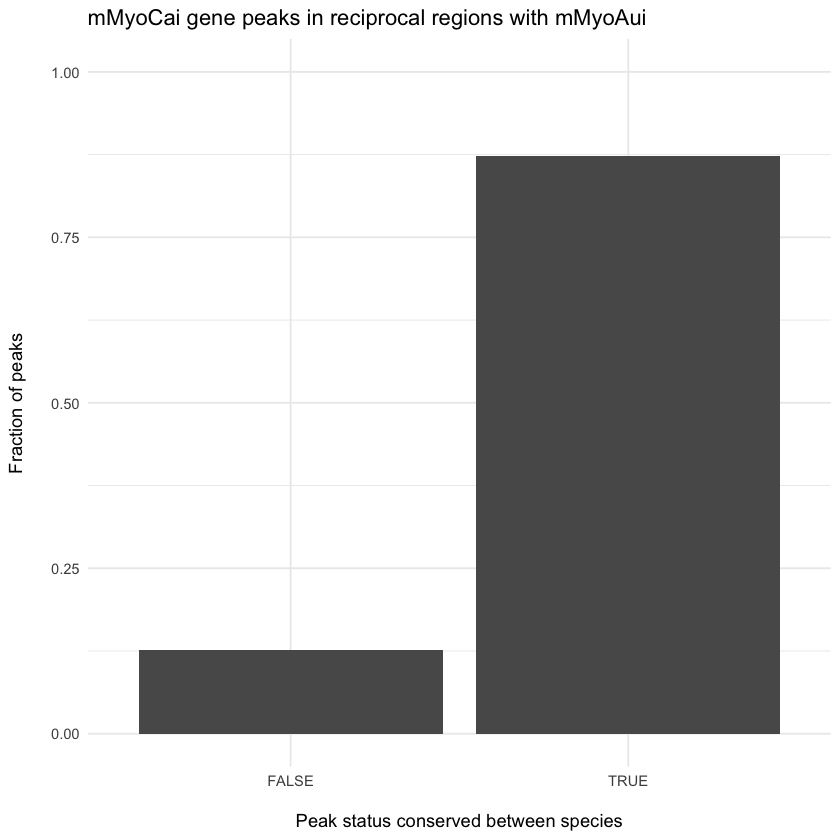

In [153]:
print(
  ggplot(spec1_frac_diff, aes(x = Peak, y = n)) + 
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_text(margin = margin(t = 15)),
          axis.title.y = element_text(margin = margin(r = 15))) +
    labs(title = paste(myo_meta$Abbr[i], "gene peaks in reciprocal regions with", myo_meta$Abbr[j])) +
    xlab("Peak status conserved between species") +
    ylab("Fraction of peaks") +
    scale_y_continuous(breaks = seq(0, 1, by = .25), limits = c(0, 1))
)

print(
  ggplot(spec2_frac_diff, aes(x = Peak, y = n)) + 
    geom_bar(stat = "identity") +
    theme_minimal() +
    theme(axis.title.x = element_text(margin = margin(t = 15)),
          axis.title.y = element_text(margin = margin(r = 15))) +
    labs(title = paste(myo_meta$Abbr[j], "gene peaks in reciprocal regions with", myo_meta$Abbr[i])) +
    xlab("Peak status conserved between species") +
    ylab("Fraction of peaks") +
    scale_y_continuous(breaks = seq(0, 1, by = .25), limits = c(0, 1))
)